In [2]:
# reload magics
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datasets
from project_modules.io import load_dataset_to_df
from project_modules.classifcation import classify_MP,getXY, boruta_fs
from project_modules.utils import MPutils
from sklearn.ensemble import RandomForestClassifier
import multiprocessing
from sklearn.model_selection import cross_val_score
# import cupy as cp
from datetime import datetime

from tqdm.notebook import tqdm
from copy import deepcopy

import umap
import matplotlib.colors as mc

import colorcet as cc
from sklearn.pipeline import Pipeline
# clustering
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import json

import shap
# from project_modules.utils import get_logger
# logger = get_logger("log-data-combine-split.log")
# # read the parameter file

# from project_modules.utils import read_parameters
# parms = read_parameters("/Users/david/projects/lc-project-data/project.yaml")

pd.options.display.max_columns = None
pd.options.display.max_rows = 50

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
saveDir = MPutils.get_saving_dir('OUTPUT/MP/05-classifiers-plot/')

In [4]:
palette = cc.glasbey_hv

# create a palette dictionary that has the same keys as the original palette
palette_dict = {i: mc.to_hex(palette[i]) for i in range(len(palette))} # type: ignore

# add an entry for -1
palette_dict[-1] = '#ffffff'

# set default colour for seaborn heatmaps
sns.set_theme(style = "whitegrid", rc={'figure.figsize':(8,8)}, palette='viridis')

with open('JSON/selectFeaturePalette.json') as f: paletteSel = json.load(f)
with open('JSON/selectFeaturePalette_NiceFeat.json') as f: paletteSel_NF = json.load(f)
with open('JSON/selectFeaturePalette_NiceFeatFlipped.json') as f: paletteSel_NFF = json.load(f)


Import Data

In [5]:
# IMPORT DATA
import pickle
# Load data (deserialize)
with open('./OUTPUT/MP/GlobalHoldoutDataDict.pickle', 'rb') as handle:
    globalDict = pickle.load(handle)
    
globalDict.keys()

dict_keys(['featlist', 'site', 'data', 'savedir', 'featDir', 'selCols', 'x_h', 'y_h', 'x_Tr', 'y_Tr', 'x_h_scaled', 'umapRes', 'umap', 'holdoutDF'])

In [6]:
globalDict['holdoutDF'].LC_STATUS.value_counts()

LC_STATUS
0    661
1    437
Name: count, dtype: int64

# Drop Vaccination -- Oct 10 2024 update
- due to the fact that with vaccination, the results implied that NOT vaccinated people were less likely to get long COVID, which is not true as per other literature -- see '2024_10_03_VaccinationImpact.ipynb'

In [7]:
globalDict['x_h'] = globalDict['x_h'].drop(columns=['VAX-vaccinated'])

In [8]:
globalDict['x_Tr'] = globalDict['x_Tr'].drop(columns=['VAX-vaccinated'])

In [9]:
globalDict['x_h_scaled'] = globalDict['x_h_scaled'].drop(columns=['VAX-vaccinated'])

## setup UMAP Figure

/root/anaconda3/envs/R2024_LCO/lib/python3.11/site-packages/umap/umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/root/anaconda3/envs/R2024_LCO/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/tmp/ipykernel_344316/3498653423.py:26: UserWarning: The palette list has more values (256) than needed (2), which may not be intended.
  sns.scatterplot(data=dfumap, x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=1, edgecolor='black', linewidth=0.5) #ax=ax[splot]


<Axes: xlabel='0', ylabel='1'>

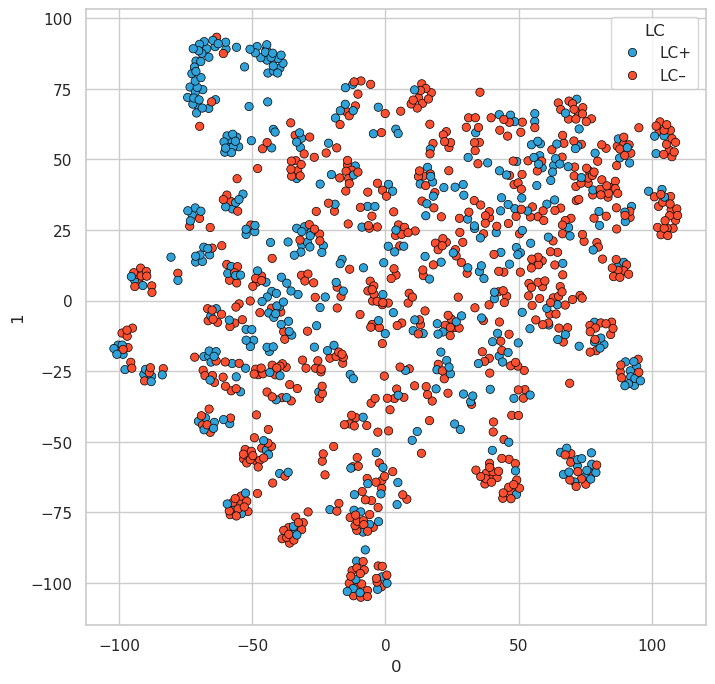

In [10]:
# UMAP
umap_parms = {
                'n_components': 2,
                'spread':       50.0,
                'random_state': 42,
                'n_neighbors': int(globalDict['x_h'].shape[0]*0.2),
                'min_dist': 0.1
            }

scaler = MinMaxScaler().set_output(transform = "pandas")
x_h_scaled = scaler.fit_transform(globalDict['x_h'])

globalDict['x_h_scaled'] = x_h_scaled

mapper = umap.UMAP(**umap_parms, verbose=False)
mapper.fit(x_h_scaled)


dfumap = pd.DataFrame(mapper.embedding_, index=x_h_scaled.index)
dfumap['LC'] = globalDict['data'].loc[x_h_scaled.index]['LC_STATUS'].map({0:'LC–',1:'LC+'})

globalDict['umapRes'] = mapper
globalDict['umap'] = dfumap

#plot umap
sns.scatterplot(data=dfumap, x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=1, edgecolor='black', linewidth=0.5) #ax=ax[splot]

# setup SHAP

In [11]:
nicefeat = pd.read_csv('OUTPUT/MP/niceFeatures.csv')
nicefeat = nicefeat.set_index('feature')
nicefeatclean = nicefeat['clean'].to_dict()
nicefeatcleanflipped = nicefeat['clean_flip'].to_dict()

In [12]:
globalDict['y_h'].value_counts()

LC_STATUS
0    661
1    437
Name: count, dtype: int64

In [13]:
from project_modules.classifcation import _shap_analysis as davidShap

model = RandomForestClassifier(n_estimators=1000, max_depth=10,random_state=42)


x_Tr_global = deepcopy(globalDict['x_Tr']).rename(columns=nicefeatclean) #nicefeatcleanflipped
y_Tr_global = deepcopy(globalDict['y_Tr'])

x_h_global = deepcopy(globalDict['x_h']).rename(columns=nicefeatclean) #nicefeatcleanflipped


model.fit(x_Tr_global,y_Tr_global)

explainer = shap.TreeExplainer(model)

explanation = explainer(x_h_global)

In [14]:
y_Tr_global.value_counts()

LC_STATUS
0    1983
1    1316
2      49
Name: count, dtype: int64

In [15]:
x_h_global

,Age,CoV Oxygen,PMHx Respiratory Tract,CoV Chest Pain,CoV Cough,CoV Dizziness,CoV Extremity Weakness/Numbness,CoV Fatigue,CoV Headache,CoV Rhinorrhea,CoV Dyspnea,CoV Sore Throat,CoV Weight Loss,PMHx Obesity,PMHx Psychiatric Disease,PMHx Sleep Disorder,CoV Vasopressor/Inotrope,CoV Anticoagulant,CoV Antibiotics,LC+ Respiratory Unknown Origin
0,34.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
1,55.0,0.0,0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
2,49.0,0.0,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
3,48.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
4,23.0,0.0,0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,32.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
1111,42.0,1.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
1112,85.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
1113,34.0,0.0,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0


In [16]:
globalDict['x_h'].shape

(1098, 20)

In [17]:
dfShapFI = davidShap.shap_get_feature_importance(explainer,explanation,X=globalDict['x_h'],top_N=10)
dfShapFI['FeatureClean'] = dfShapFI.Feature.map(nicefeatclean)
dfShapFI['FeatureCleanFlipped'] = dfShapFI.Feature.map(nicefeatcleanflipped)
dfShapFI

>>> SHAP feature importance
--------------------------------------------------
>>> ... Top 10 features: ['SYMPT-dizziness___1' 'age' 'SYMPT-shortness_of_breath_dyspne___1'
 'SYMPT-sore_throat___1' 'SYMPT-runny_nose_rhinorrhea___1'
 'CD-medication_received___5' 'SYMPT-fatigue___1' 'SYMPT-cough___1'
 'SYMPT-chest_pain___1' 'SYMPT-headache___1']


,Feature,Importance,FeatureClean,FeatureCleanFlipped
0,SYMPT-dizziness___1,1.000000,CoV Dizziness,Dizziness CoV
1,age,0.975745,Age,Age
2,SYMPT-shortness_of_breath_dyspne___1,0.665965,CoV Dyspnea,Dyspnea CoV
3,SYMPT-sore_throat___1,0.586665,CoV Sore Throat,Sore Throat CoV
4,SYMPT-runny_nose_rhinorrhea___1,0.513411,CoV Rhinorrhea,Rhinorrhea CoV
5,CD-medication_received___5,0.433777,CoV Antibiotics,Antibiotics CoV
6,SYMPT-fatigue___1,0.340663,CoV Fatigue,Fatigue CoV
7,SYMPT-cough___1,0.332730,CoV Cough,Cough CoV
8,SYMPT-chest_pain___1,0.244934,CoV Chest Pain,Chest Pain CoV
9,SYMPT-headache___1,0.206548,CoV Headache,Headache CoV


In [18]:
explanation.shape

(1098, 20, 3)

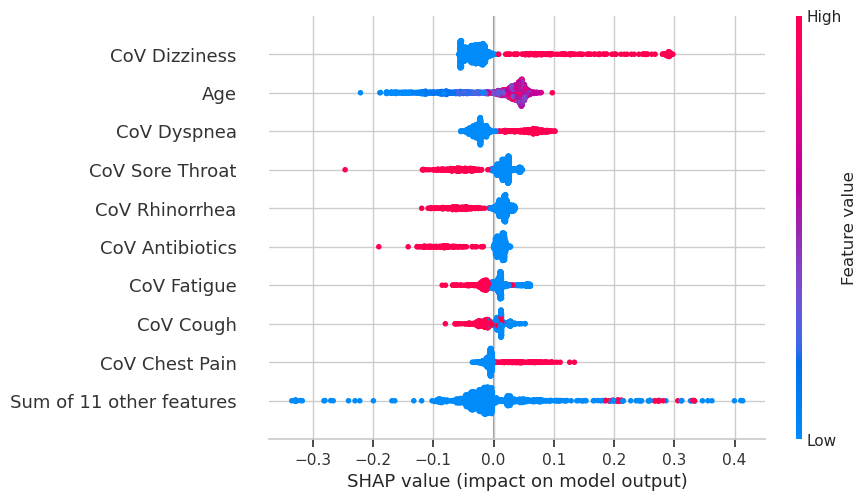

In [19]:
shap.plots.beeswarm(explanation[:,:,1],max_display=10)

# setup ROC

In [20]:
random_state = 42
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import RocCurveDisplay, auc

def plotROCCurve(ax,fontsize=10):
    n_splits = 5
    cv = StratifiedKFold(n_splits=n_splits)
    # classifier = svm.SVC(kernel="linear", probability=True, random_state=random_state)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    classifier = RandomForestClassifier(n_estimators=1000,max_depth=10,random_state=42)

    X = deepcopy(globalDict['x_h'])
    X.reset_index(drop=True,inplace=True)
    y = deepcopy(globalDict['y_h'])
    y.reset_index(drop=True,inplace=True)

    for fold, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X.iloc[train], y.iloc[train])
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X.iloc[test],
            y.iloc[test],
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
            plot_chance_level=(fold == n_splits - 1),
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        # title=f"Mean ROC curve with variability",
        title='ROC Curve',
    )
    ax.legend(loc="lower right",fontsize=8)

# Plot Fig 1 -- without Umap - without vax - Oct 8

In [21]:
paletteSel_NF

{'CoV Vasopressor/Inotrope': [0.188235, 0.635294, 0.854902],
 'LC+ Concentration Unknown Origin': [0.988235, 0.309804, 0.188235],
 'CoV Hospitalized': [0.898039, 0.682353, 0.219608],
 'CoV Steroids': [0.427451, 0.564706, 0.309804],
 'CoV Anticoagulant': [0.545098, 0.545098, 0.545098],
 'CoV Colchicine': [0.090196, 0.745098, 0.811765],
 'CoV Antibiotics': [0.580392, 0.403922, 0.741176],
 'LC+ Memory Unknown Origin': [0.839216, 0.152941, 0.156863],
 'CoV Oxygen': [0.121569, 0.466667, 0.705882],
 'LC+ Respiratory Unknown Origin': [0.890196, 0.466667, 0.760784],
 'CoV UnInfected': [0.54902, 0.337255, 0.294118],
 'CoV Mild': [0.737255, 0.741176, 0.133333],
 'CoV Moderate': [0.227451, 0.003922, 0.513725],
 'CoV Severe': [0.0, 0.262745, 0.0],
 'CoV SpO2': [0.058824, 1.0, 0.662745],
 '(Cov) ICU': [0.368627, 0.0, 0.25098],
 'CoV Non-ICU': [0.776471, 0.741176, 1.0],
 'PMHx Hypertension': [0.258824, 0.313725, 0.321569],
 'PMHx Asthma': [0.721569, 0.0, 0.501961],
 'PMHx Diabetes': [1.0, 0.717647, 

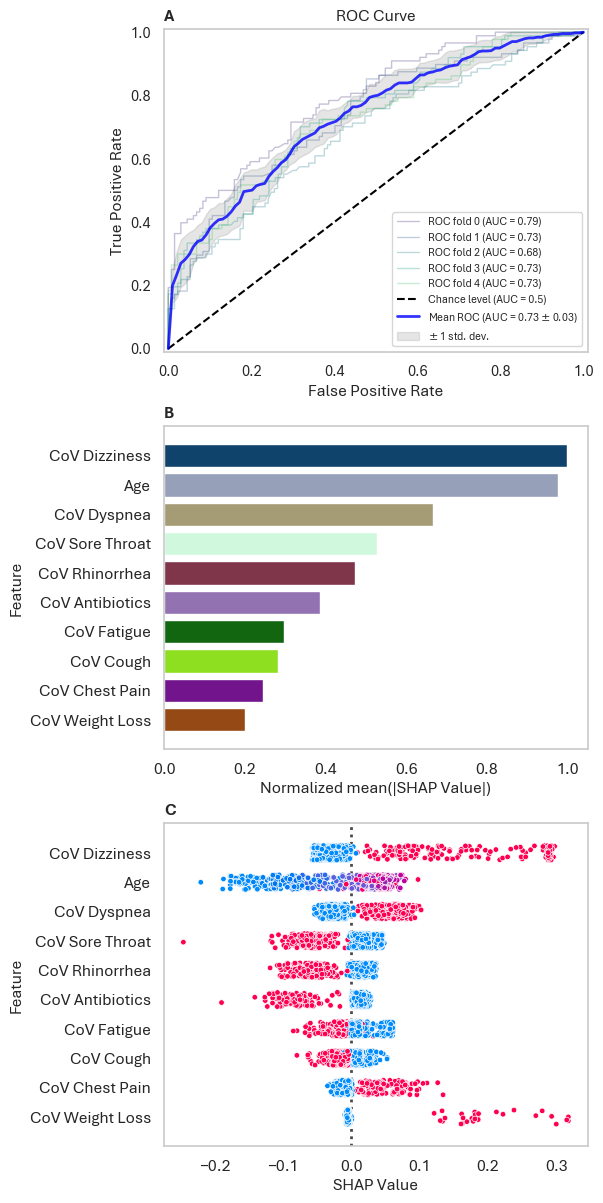

In [23]:
plt.rcParams['font.family'] = 'Aptos'
fontsize='medium'
sString = 'A;B;C'
fig, ax = plt.subplot_mosaic(sString,figsize=(6,12))

# PLOT ROC CURVE
plotROCCurve(ax['A'],fontsize)


# SHAP BAR
davidShap.shap_plot_bar(ax=ax['B'], explanation=explanation, X= x_h_global,target_class=1,plot_n_features=10,feature_palette=paletteSel_NF,fontsize=fontsize)


#SHAP Points
davidShap.shap_plot_points(ax=ax['C'], explanation=explanation, X= x_h_global,target_class=1,plot_n_features=10,fontsize=fontsize,normalize_values=False, suppress_yticks=False)

# GRID OFF
ax['A'].grid(False)
ax['B'].grid(False)
ax['C'].grid(False)

#set AB subplot identifier letters
ax['A'].set_title('A',  loc='left', fontsize='medium', fontweight='bold')
ax['B'].set_title('B', loc='left', fontsize='medium', fontweight='bold')
ax['C'].set_title('C', loc='left', fontsize='medium', fontweight='bold')

# Make all subplots the same size and shape
for key in ax:
    ax[key].set_aspect(aspect='auto', anchor='C')
    
# Adjust the spacing between subplots
fig.tight_layout(pad=0.5)
    
# SAVE
plt.savefig(f'{saveDir}/Fig1-Global/Fig1-Global-ROC-SHAPFR-SHAPVal.jpg', dpi=800, bbox_inches='tight', facecolor='white')

# depreciated as of Oct 8 -  Plot Fig 1 -- without Umap - Aug 22 -- with Vaccination Problem

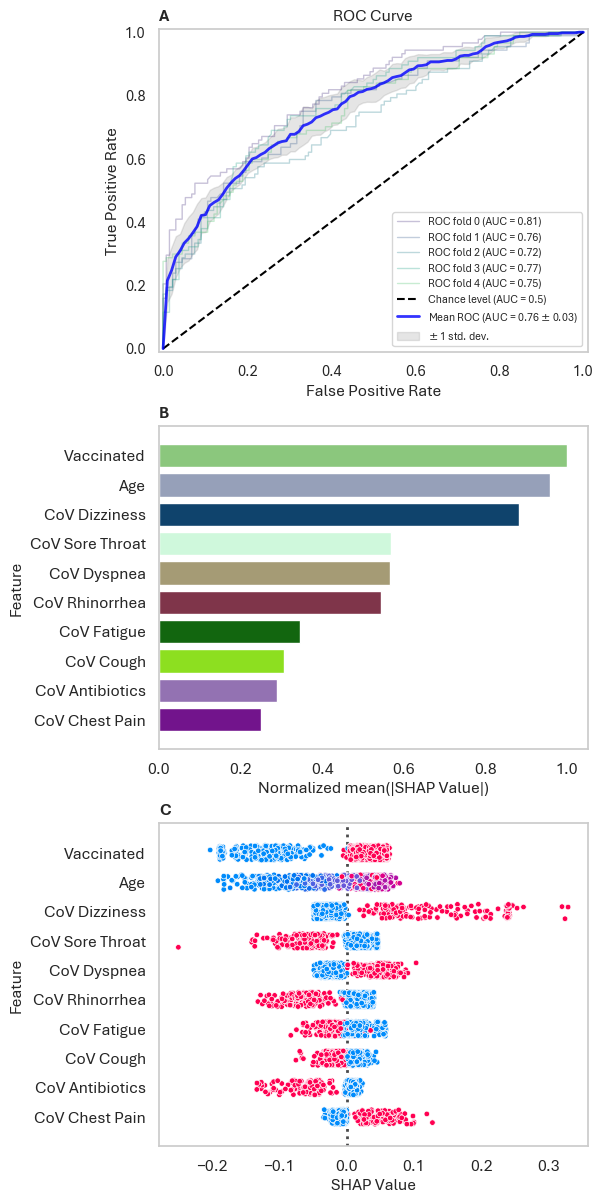

In [ ]:
plt.rcParams['font.family'] = 'Aptos'
fontsize='medium'
sString = 'A;B;C'
fig, ax = plt.subplot_mosaic(sString,figsize=(6,12))

# PLOT ROC CURVE
plotROCCurve(ax['A'],fontsize)


# SHAP BAR
davidShap.shap_plot_bar(ax=ax['B'], explanation=explanation, X= x_h_global,target_class=1,plot_n_features=10,feature_palette=paletteSel_NF,fontsize=fontsize)


#SHAP Points
davidShap.shap_plot_points(ax=ax['C'], explanation=explanation, X= x_h_global,target_class=1,plot_n_features=10,fontsize=fontsize,normalize_values=False, suppress_yticks=False)

# GRID OFF
ax['A'].grid(False)
ax['B'].grid(False)
ax['C'].grid(False)

#set AB subplot identifier letters
ax['A'].set_title('A',  loc='left', fontsize='medium', fontweight='bold')
ax['B'].set_title('B', loc='left', fontsize='medium', fontweight='bold')
ax['C'].set_title('C', loc='left', fontsize='medium', fontweight='bold')

# Make all subplots the same size and shape
for key in ax:
    ax[key].set_aspect(aspect='auto', anchor='C')
    
# Adjust the spacing between subplots
fig.tight_layout(pad=0.5)
    
# SAVE
plt.savefig(f'{saveDir}/Fig1-Global/Fig1-Global-ROC-SHAPFR-SHAPVal.jpg', dpi=800, bbox_inches='tight', facecolor='white')

# depreciated as of Aug 22 -- Plot Fig 1 -- with umap -- 

/tmp/ipykernel_7582/1769685994.py:10: UserWarning: The palette list has more values (256) than needed (2), which may not be intended.
  sns.scatterplot(data=globalDict['umap'], x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=0.5, ax=ax['B'], edgecolor='black', linewidth=0.5, s=25)


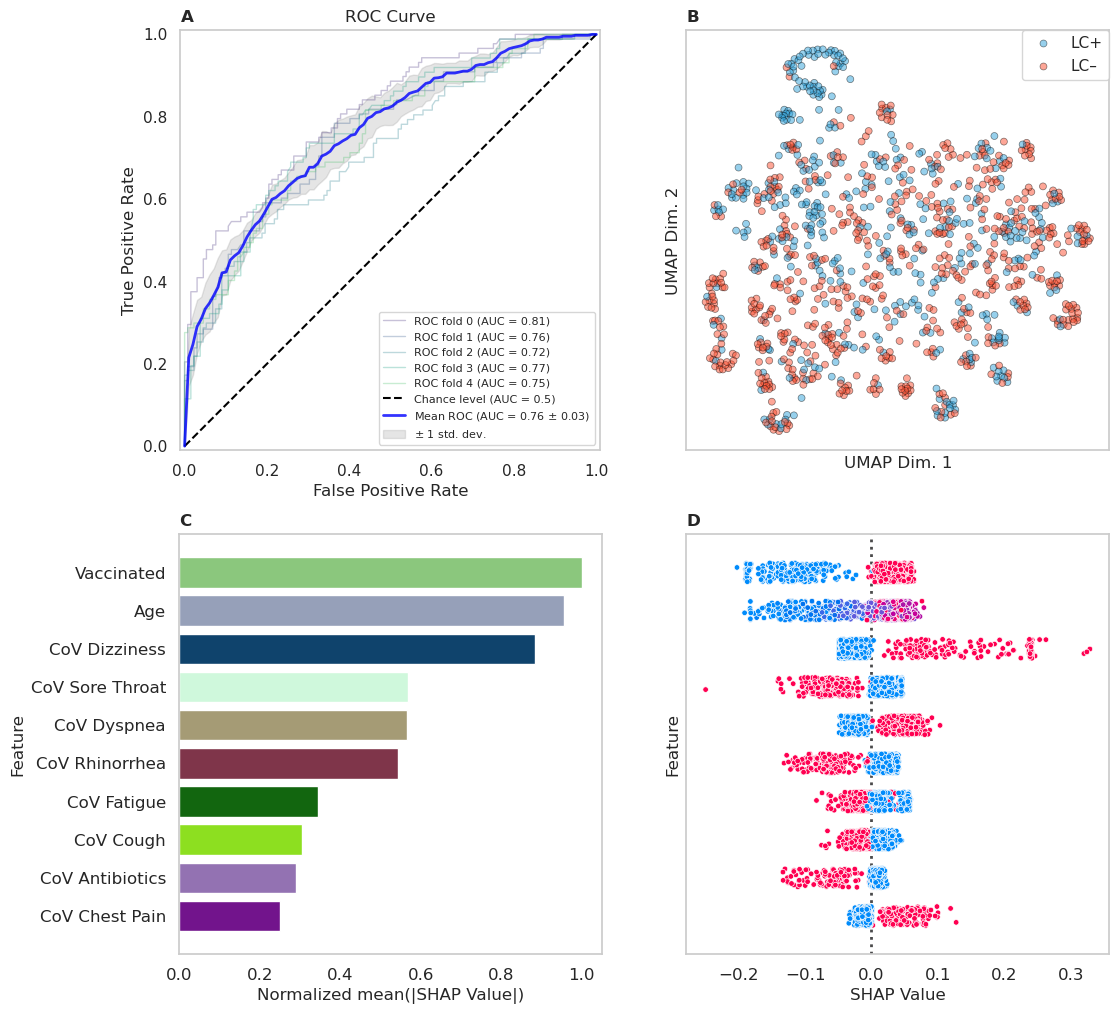

In [36]:
fontsize='medium'
sString = 'AB;CD'
fig, ax = plt.subplot_mosaic(sString,figsize=(12,12))

# PLOT ROC CURVE
plotROCCurve(ax['A'],fontsize)

# PLOT UMAP/SCATTER
sns.scatterplot(data=globalDict['umap'], x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=0.5, ax=ax['B'], edgecolor='black', linewidth=0.5, s=25)

#setup plot
ax['B'].legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.)
ax['B'].set_xticks([]); ax['B'].set_yticks([])
ax['B'].set_xlabel("UMAP Dim. 1"); ax['B'].set_ylabel("UMAP Dim. 2")


# SHAP BAR
davidShap.shap_plot_bar(ax=ax['C'], explanation=explanation, X= x_h_global,target_class=1,plot_n_features=10,feature_palette=paletteSel_NF,fontsize=fontsize)


#SHAP Points
davidShap.shap_plot_points(ax=ax['D'], explanation=explanation, X= x_h_global,target_class=1,plot_n_features=10,fontsize=fontsize,normalize_values=False, suppress_yticks=True)

# GRID OFF
ax['A'].grid(False)
ax['B'].grid(False)
ax['C'].grid(False)
ax['D'].grid(False)

#set AB subplot identifier letters
ax['A'].set_title('A',  loc='left', fontsize='medium', fontweight='bold')
ax['B'].set_title('B', loc='left', fontsize='medium', fontweight='bold')
ax['C'].set_title('C', loc='left', fontsize='medium', fontweight='bold')
ax['D'].set_title('D', loc='left', fontsize='medium', fontweight='bold')

# SAVE
# plt.savefig(f'{saveDir}/Fig1-Global/Fig1-Global-ROC-UMAP-SHAPFR-SHAPVal.jpg', dpi=800, bbox_inches='tight', facecolor='white')